In [39]:
from openbb_terminal.sdk import openbb
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report


%matplotlib inline

In [12]:
#setup for multiple stocks & close prices
start = "2018-01-01"
end = "2023-04-10"

symbols = ["SPY", "QQQ", "IWM", "GLD", "TLT"]

stock_data = openbb.economy.index(symbols, start_date = start, end_date = end)
stock_data

,SPY,QQQ,IWM,GLD,TLT
Date,,,,,
2018-01-02,245.828415,152.886780,143.941132,125.150002,112.310905
2018-01-03,247.383301,154.372375,144.090805,124.820000,112.847855
2018-01-04,248.426010,154.642487,144.474274,125.459999,112.829971
2018-01-05,250.081467,156.195526,144.773575,125.330002,112.507767
2018-01-08,250.538834,156.803223,144.998047,125.309998,112.436180
...,...,...,...,...,...
2023-03-31,409.390015,320.929993,178.399994,183.220001,106.101006
2023-04-03,410.950012,320.149994,178.479996,184.539993,106.599998
2023-04-04,408.670013,319.070007,175.350006,187.979996,107.129997


<AxesSubplot: title={'left': 'Index Overview - 5yr Daily'}, xlabel='Date'>

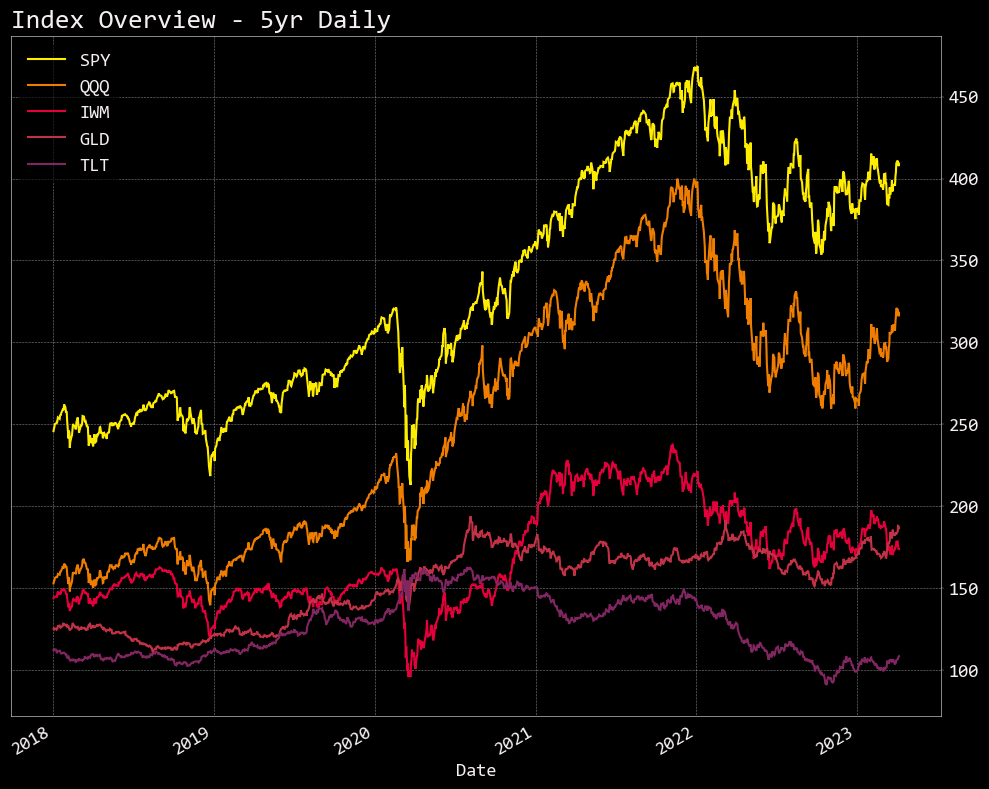

In [13]:
# Quick Examine of the Daily Plot to level set the overall environment 
stock_data.plot(
    title="Index Overview - 5yr Daily",
    figsize=(12,10)
)

In [24]:
#Drill into single issue --> IWM: russel2k etf
iwm_data = openbb.stocks.load(
        symbol = 'IWM',
        start_date = start,
        monthly = False)
iwm_data.head()

Loading Daily data for IWM with starting period 2018-01-02.

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
date,,,,,,,,
2018-01-02,143.286477,144.006655,142.594371,143.941177,143.941177,20489600,0.0,0.0
2018-01-03,143.913098,144.464930,143.585755,144.090805,144.090805,21836600,0.0,0.0
2018-01-04,144.941934,145.110279,144.053411,144.474289,144.474289,14207100,0.0,0.0
2018-01-05,144.857747,144.951267,143.978571,144.773560,144.773560,19883900,0.0,0.0
2018-01-08,144.717457,145.222522,143.567054,144.998047,144.998047,18457300,0.0,0.0


Loading Daily data for IWM with starting period 2020-04-08.

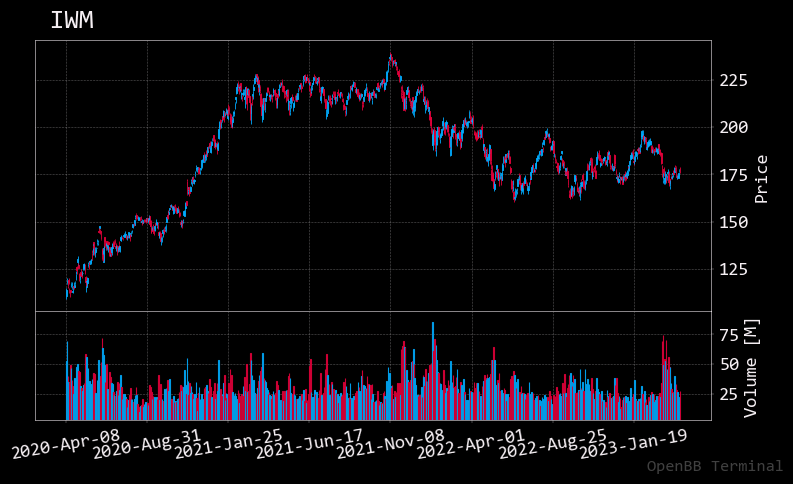

In [25]:
#Zoom in to get a feel for our data on both daily and intraday windows
openbb.stocks.candle("IWM")

Loading Intraday 15min data for IWM with starting period 2023-02-13.

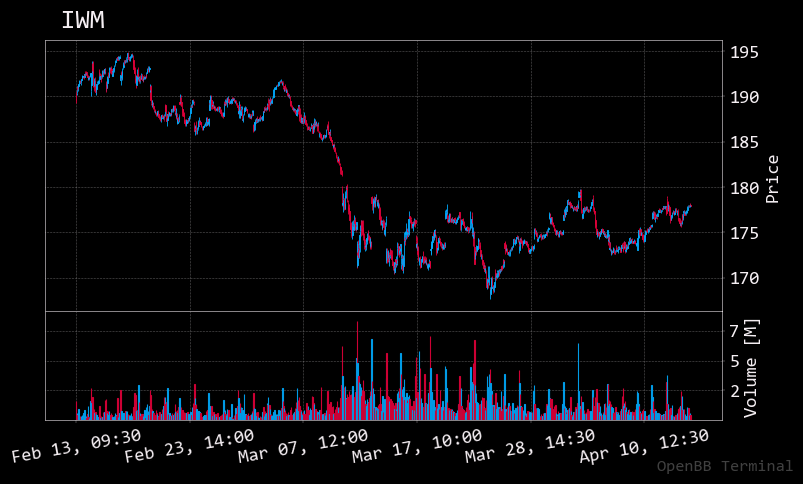

In [26]:
openbb.stocks.candle("IWM", interval=15)

In [27]:
# Begin "manual" ML process for IWM

# remove split & dividends from df
iwm_data = iwm_data.drop(columns=["Dividends", "Stock Splits"])

# Filter the date index and close columns
iwm_signals_df = iwm_data.loc[:, ["Close"]]

# Use the pct_change function to generate returns from close prices
iwm_signals_df["Actual Returns"] = iwm_signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
iwm_signals_df = iwm_signals_df.dropna()

# Review the DataFrame
display(iwm_signals_df.head())
display(iwm_signals_df.tail())

,Close,Actual Returns
date,,
2018-01-03,144.090805,0.001040
2018-01-04,144.474289,0.002661
2018-01-05,144.773560,0.002071
2018-01-08,144.998047,0.001551
2018-01-09,144.801636,-0.001355


,Close,Actual Returns
date,,
2023-04-05,173.630005,-0.009809
2023-04-06,173.889999,0.001497
2023-04-10,175.750000,0.010696
2023-04-11,177.139999,0.007909
2023-04-12,175.839996,-0.007339


In [28]:
# Set the short window and long window (10 & 60 as this will be comparison later to openbb signals)
short_window = 10
long_window = 60

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
iwm_signals_df['SMA_Short(10)'] = iwm_signals_df['Close'].rolling(window=short_window).mean()
iwm_signals_df['SMA_Long(60)'] = iwm_signals_df['Close'].rolling(window=long_window).mean()

#drop any null values
iwm_signals_df = iwm_signals_df.dropna()

# Review the DataFrame
display(iwm_signals_df.head())
display(iwm_signals_df.tail())

,Close,Actual Returns,SMA_Short(10),SMA_Long(60)
date,,,,
2018-03-29,142.332962,0.010112,143.922385,144.487356
2018-04-02,138.864410,-0.024369,143.049948,144.400250
2018-04-03,140.851776,0.014312,142.518411,144.339875
2018-04-04,142.642349,0.012712,142.169670,144.304354
2018-04-05,143.823517,0.008281,141.853937,144.284779


,Close,Actual Returns,SMA_Short(10),SMA_Long(60)
date,,,,
2023-04-05,173.630005,-0.009809,174.564998,183.839677
2023-04-06,173.889999,0.001497,174.928998,183.740404
2023-04-10,175.750000,0.010696,175.324998,183.634769
2023-04-11,177.139999,0.007909,175.668999,183.501322
2023-04-12,175.839996,-0.007339,175.907999,183.325949


In [29]:
# Initialize the new Signal column
iwm_signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
iwm_signals_df.loc[(iwm_signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
iwm_signals_df.loc[(iwm_signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(iwm_signals_df.head())
display(iwm_signals_df.tail())

,Close,Actual Returns,SMA_Short(10),SMA_Long(60),Signal
date,,,,,
2018-03-29,142.332962,0.010112,143.922385,144.487356,1.0
2018-04-02,138.864410,-0.024369,143.049948,144.400250,-1.0
2018-04-03,140.851776,0.014312,142.518411,144.339875,1.0
2018-04-04,142.642349,0.012712,142.169670,144.304354,1.0
2018-04-05,143.823517,0.008281,141.853937,144.284779,1.0


,Close,Actual Returns,SMA_Short(10),SMA_Long(60),Signal
date,,,,,
2023-04-05,173.630005,-0.009809,174.564998,183.839677,-1.0
2023-04-06,173.889999,0.001497,174.928998,183.740404,1.0
2023-04-10,175.750000,0.010696,175.324998,183.634769,1.0
2023-04-11,177.139999,0.007909,175.668999,183.501322,1.0
2023-04-12,175.839996,-0.007339,175.907999,183.325949,-1.0


In [30]:
# Check to see distribution of signals
iwm_signals_df['Signal'].value_counts()

 1.0    676
-1.0    592
Name: Signal, dtype: int64

In [31]:
# Calculate the strategy returns and add them to the signals_df DataFrame
iwm_signals_df['Strategy Returns'] = iwm_signals_df['Actual Returns'] * iwm_signals_df['Signal'].shift()

# Review the DataFrame
display(iwm_signals_df.head())
display(iwm_signals_df.tail())

,Close,Actual Returns,SMA_Short(10),SMA_Long(60),Signal,Strategy Returns
date,,,,,,
2018-03-29,142.332962,0.010112,143.922385,144.487356,1.0,NaN
2018-04-02,138.864410,-0.024369,143.049948,144.400250,-1.0,-0.024369
2018-04-03,140.851776,0.014312,142.518411,144.339875,1.0,-0.014312
2018-04-04,142.642349,0.012712,142.169670,144.304354,1.0,0.012712
2018-04-05,143.823517,0.008281,141.853937,144.284779,1.0,0.008281


,Close,Actual Returns,SMA_Short(10),SMA_Long(60),Signal,Strategy Returns
date,,,,,,
2023-04-05,173.630005,-0.009809,174.564998,183.839677,-1.0,0.009809
2023-04-06,173.889999,0.001497,174.928998,183.740404,1.0,-0.001497
2023-04-10,175.750000,0.010696,175.324998,183.634769,1.0,0.010696
2023-04-11,177.139999,0.007909,175.668999,183.501322,1.0,0.007909
2023-04-12,175.839996,-0.007339,175.907999,183.325949,-1.0,-0.007339


<AxesSubplot: xlabel='date'>

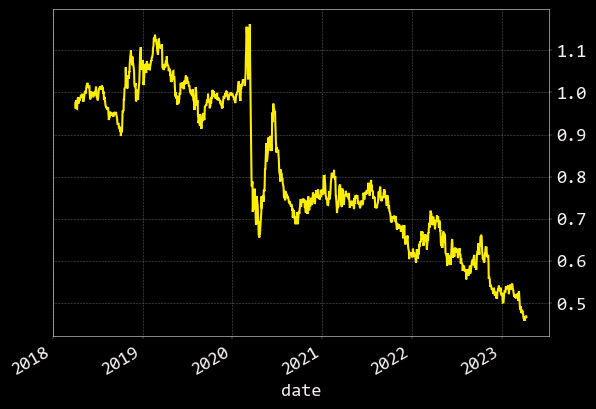

In [32]:
# Plot Strategy Returns to examine performance
(1 + iwm_signals_df['Strategy Returns']).cumprod().plot()

### Split the data into training and testing datasets.

In [35]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = iwm_signals_df[['SMA_Short(10)', 'SMA_Long(60)']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Short(10),SMA_Long(60)
date,,
2018-04-02,143.922385,144.487356
2018-04-03,143.049948,144.400250
2018-04-04,142.518411,144.339875
2018-04-05,142.169670,144.304354
2018-04-06,141.853937,144.284779


In [36]:
# Create the target set selecting the Signal column and assiging it to y
y = iwm_signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    676
-1.0    592
Name: Signal, dtype: int64

In [37]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2018-04-02 00:00:00


In [41]:
# Select the ending period for the training data with an offset of 2 years
training_end = X.index.min() + DateOffset(years=2)

# Display the training end date
print(training_end)

2020-04-02 00:00:00


In [42]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Short(10),SMA_Long(60)
date,,
2018-04-02,143.922385,144.487356
2018-04-03,143.049948,144.400250
2018-04-04,142.518411,144.339875
2018-04-05,142.169670,144.304354
2018-04-06,141.853937,144.284779


In [43]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

,SMA_Short(10),SMA_Long(60)
date,,
2020-04-03,105.182189,140.686431
2020-04-06,105.529861,139.722647
2020-04-07,106.792723,138.884217
2020-04-08,107.206781,138.060352
2020-04-09,107.986754,137.302033


In [44]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [46]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [47]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.28      0.01      0.03       360
         1.0       0.52      0.97      0.68       401

    accuracy                           0.52       761
   macro avg       0.40      0.49      0.35       761
weighted avg       0.41      0.52      0.37       761



In [49]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = iwm_signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df["Predicted"] * predictions_df["Actual Returns"]

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2020-04-03,1.0,-0.028327,-0.028327
2020-04-06,1.0,0.076563,0.076563
2020-04-07,1.0,0.002575,0.002575
2020-04-08,1.0,0.045608,0.045608
2020-04-09,1.0,0.047853,0.047853


,Predicted,Actual Returns,Strategy Returns
date,,,
2023-04-05,1.0,-0.009809,-0.009809
2023-04-06,1.0,0.001497,0.001497
2023-04-10,1.0,0.010696,0.010696
2023-04-11,1.0,0.007909,0.007909
2023-04-12,1.0,-0.007339,-0.007339


<AxesSubplot: title={'left': 'Actual vs Strategy'}, xlabel='date', ylabel='cum returns'>

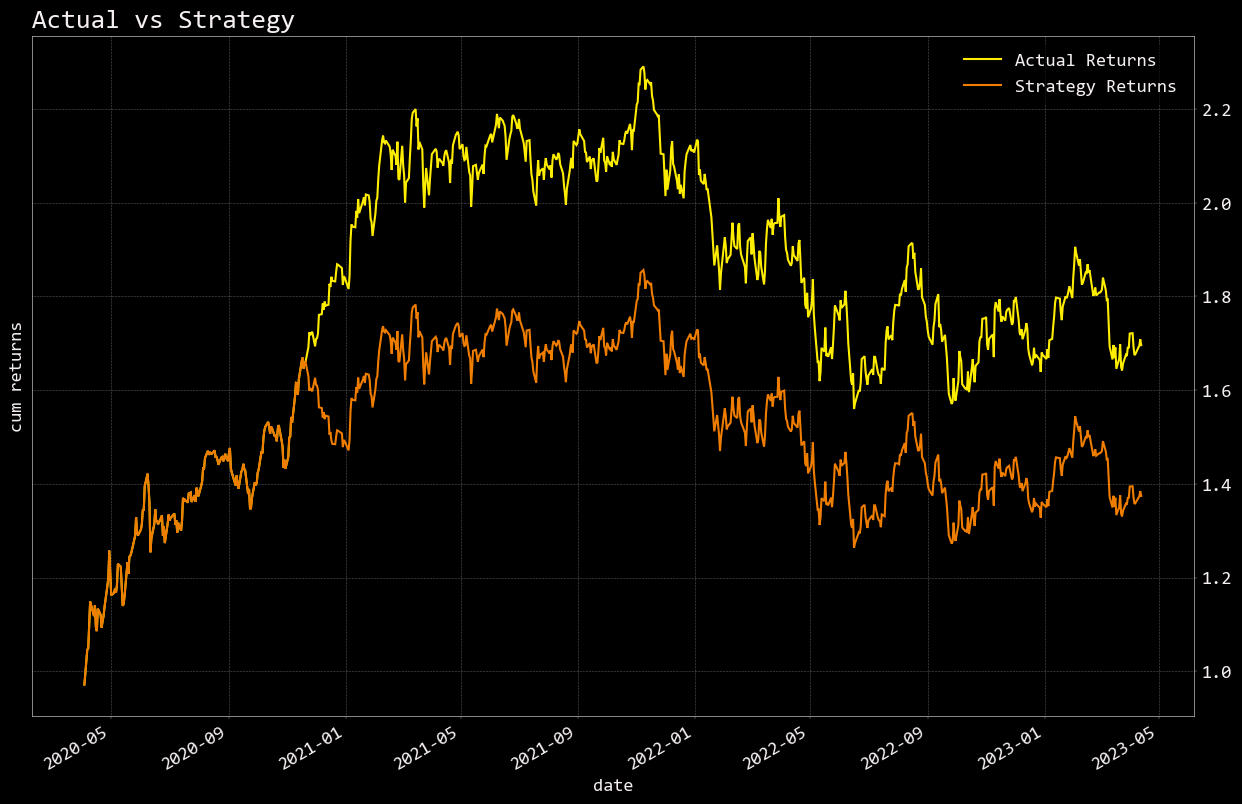

In [50]:
# Plot the actual returns versus the strategy returns
baseline = (1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(
    title = "Actual vs Strategy",
    figsize = (15,10),
    ylabel="cum returns"

)
baseline

In [ ]:
# up to this point a lot of work to determine:
# 1. The strategy itself did NOT perform well in the backtest as compared to the actual returns
# 2. The SVM predictive model had poor precision and accuracy and would need alot of additional work before deploying to predict price

In [52]:
# Use the signals function
# Use the predictive modeling function to QUICKLY train test predict and evaluate a regression model

In [53]:
iwm_data

,Open,High,Low,Close,Adj Close,Volume
date,,,,,,
2018-01-02,143.286477,144.006655,142.594371,143.941177,143.941177,20489600
2018-01-03,143.913098,144.464930,143.585755,144.090805,144.090805,21836600
2018-01-04,144.941934,145.110279,144.053411,144.474289,144.474289,14207100
2018-01-05,144.857747,144.951267,143.978571,144.773560,144.773560,19883900
2018-01-08,144.717457,145.222522,143.567054,144.998047,144.998047,18457300
...,...,...,...,...,...,...
2023-04-05,174.250000,174.830002,172.529999,173.630005,173.630005,28247300
2023-04-06,173.720001,174.460007,172.679993,173.889999,173.889999,26366300
2023-04-10,173.070007,175.880005,173.029999,175.750000,175.750000,22237800


In [55]:
# 1 if the signal is that short term price will go up as compared to the long term.
# 0 if the signal is that short term price will go down as compared to the long term.

# Create short simple moving average; the short window defaults to 10 period
# Create long simple moving average; the long window defaults to 60 period

# Single line calculates the short and long SMA's and determines the 1 or 0 for us!!

new_iwm_df = openbb.forecast.signal(iwm_data, target_column = "Adj Close")
new_iwm_df

,Open,High,Low,Close,Adj Close,Volume,signal
date,,,,,,,
2018-01-02,143.286477,144.006655,142.594371,143.941177,143.941177,20489600,0.0
2018-01-03,143.913098,144.464930,143.585755,144.090805,144.090805,21836600,0.0
2018-01-04,144.941934,145.110279,144.053411,144.474289,144.474289,14207100,0.0
2018-01-05,144.857747,144.951267,143.978571,144.773560,144.773560,19883900,0.0
2018-01-08,144.717457,145.222522,143.567054,144.998047,144.998047,18457300,0.0
...,...,...,...,...,...,...,...
2023-04-05,174.250000,174.830002,172.529999,173.630005,173.630005,28247300,0.0
2023-04-06,173.720001,174.460007,172.679993,173.889999,173.889999,26366300,0.0
2023-04-10,173.070007,175.880005,173.029999,175.750000,175.750000,22237800,0.0


Warning: when using past covariates n_predict must equal output_chunk_length. We have changed your output_chunk_length to 100 to match your n_predict

Covariate #0: Volume

Predicting Regression for 100 days


  0%|          | 0/341 [00:00<?, ?it/s]

Regression model obtains MAPE: 2.99%

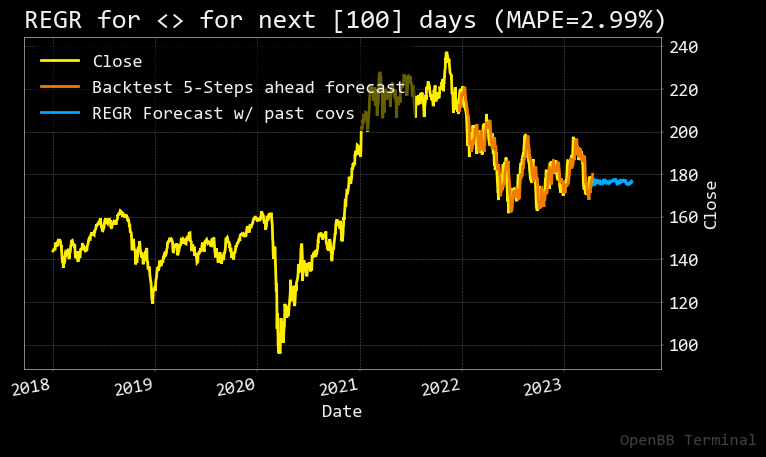

   Actual price: 175.84    
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Datetime   ┃ Prediction ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ 2023-04-13 │ 175.07     │
├────────────┼────────────┤
│ 2023-04-14 │ 175.55     │
├────────────┼────────────┤
│ 2023-04-17 │ 174.75     │
├────────────┼────────────┤
│ 2023-04-18 │ 175.93     │
├────────────┼────────────┤
│ 2023-04-19 │ 175.77     │
├────────────┼────────────┤
│ 2023-04-20 │ 176.44     │
├────────────┼────────────┤
│ 2023-04-21 │ 177.03     │
├────────────┼────────────┤
│ 2023-04-24 │ 176.55     │
├────────────┼────────────┤
│ 2023-04-25 │ 177.17     │
├────────────┼────────────┤
│ 2023-04-26 │ 176.90     │
├────────────┼────────────┤
│ 2023-04-27 │ 176.60     │
├────────────┼────────────┤
│ 2023-04-28 │ 176.86     │
├────────────┼────────────┤
│ 2023-05-01 │ 176.36     │
├────────────┼────────────┤
│ 2023-05-02 │ 176.97     │
├────────────┼────────────┤
│ 2023-05-03 │ 177.07     │
├────────────┼────────────┤
│ 2023-05-04 │ 177.03     │
├────────────┼────────────┤
│ 2023-05-05 │ 176.26     │
├────────────┼────────────┤
│ 2023-05-08 │ 176.10     │
├────────────┼────────────┤
│ 2023-05-09 │ 175.87     │
├────────────┼────────────┤
│ 2023-05-10 │ 175.52     │
├────────────┼────────────┤
│ 2023-05-11 │ 175.61     │
├────────────┼────────────┤
│ 2023-05-12 │ 176.29     │
├────────────┼────────────┤
│ 2023-05-15 │ 175.71     │
├────────────┼────────────┤
│ 2023-05-16 │ 175.70     │
├────────────┼────────────┤
│ 2023-05-17 │ 175.58     │
├────────────┼────────────┤
│ 2023-05-18 │ 176.06     │
├────────────┼────────────┤
│ 2023-05-19 │ 176.31     │
├────────────┼────────────┤
│ 2023-05-22 │ 177.45     │
├────────────┼────────────┤
│ 2023-05-23 │ 177.81     │
├────────────┼────────────┤
│ 2023-05-24 │ 176.84     │
├────────────┼────────────┤
│ 2023-05-25 │ 176.04     │
├────────────┼────────────┤
│ 2023-05-26 │ 175.97     │
├────────────┼────────────┤
│ 2023-05-29 │ 175.85     │
├────────────┼────────────┤
│ 2023-05-30 │ 176.51     │
├────────────┼────────────┤
│ 2023-05-31 │ 176.31     │
├────────────┼────────────┤
│ 2023-06-01 │ 176.44     │
├────────────┼────────────┤
│ 2023-06-02 │ 176.60     │
├────────────┼────────────┤
│ 2023-06-05 │ 176.35     │
├────────────┼────────────┤
│ 2023-06-06 │ 176.22     │
├────────────┼────────────┤
│ 2023-06-07 │ 175.32     │
├────────────┼────────────┤
│ 2023-06-08 │ 176.80     │
├────────────┼────────────┤
│ 2023-06-09 │ 176.36     │
├────────────┼────────────┤
│ 2023-06-12 │ 175.34     │
├────────────┼────────────┤
│ 2023-06-13 │ 176.80     │
├────────────┼────────────┤
│ 2023-06-14 │ 176.79     │
├────────────┼────────────┤
│ 2023-06-15 │ 176.40     │
├────────────┼────────────┤
│ 2023-06-16 │ 176.51     │
├────────────┼────────────┤
│ 2023-06-19 │ 176.51     │
├────────────┼────────────┤
│ 2023-06-20 │ 176.71     │
├────────────┼────────────┤
│ 2023-06-21 │ 176.78     │
├────────────┼────────────┤
│ 2023-06-22 │ 177.05     │
├────────────┼────────────┤
│ 2023-06-23 │ 177.26     │
├────────────┼────────────┤
│ 2023-06-26 │ 177.13     │
├────────────┼────────────┤
│ 2023-06-27 │ 176.74     │
├────────────┼────────────┤
│ 2023-06-28 │ 177.18     │
├────────────┼────────────┤
│ 2023-06-29 │ 177.88     │
├────────────┼────────────┤
│ 2023-06-30 │ 177.22     │
├────────────┼────────────┤
│ 2023-07-03 │ 177.56     │
├────────────┼────────────┤
│ 2023-07-04 │ 177.98     │
├────────────┼────────────┤
│ 2023-07-05 │ 176.42     │
├────────────┼────────────┤
│ 2023-07-06 │ 176.13     │
├────────────┼────────────┤
│ 2023-07-07 │ 175.70     │
├────────────┼────────────┤
│ 2023-07-10 │ 176.19     │
├────────────┼────────────┤
│ 2023-07-11 │ 176.19     │
├────────────┼────────────┤
│ 2023-07-12 │ 176.06     │
├────────────┼────────────┤
│ 2023-07-13 │ 177.01     │
├────────────┼────────────┤
│ 2023-07-14 │ 176.03     │
├────────────┼────────────┤
│ 2023-07-17 │ 176.21     │
├────────────┼────────────┤
│ 2023-07-18 │ 176.48     │
├────────────┼────────────┤
│ 2023-07-19 │ 176.32   

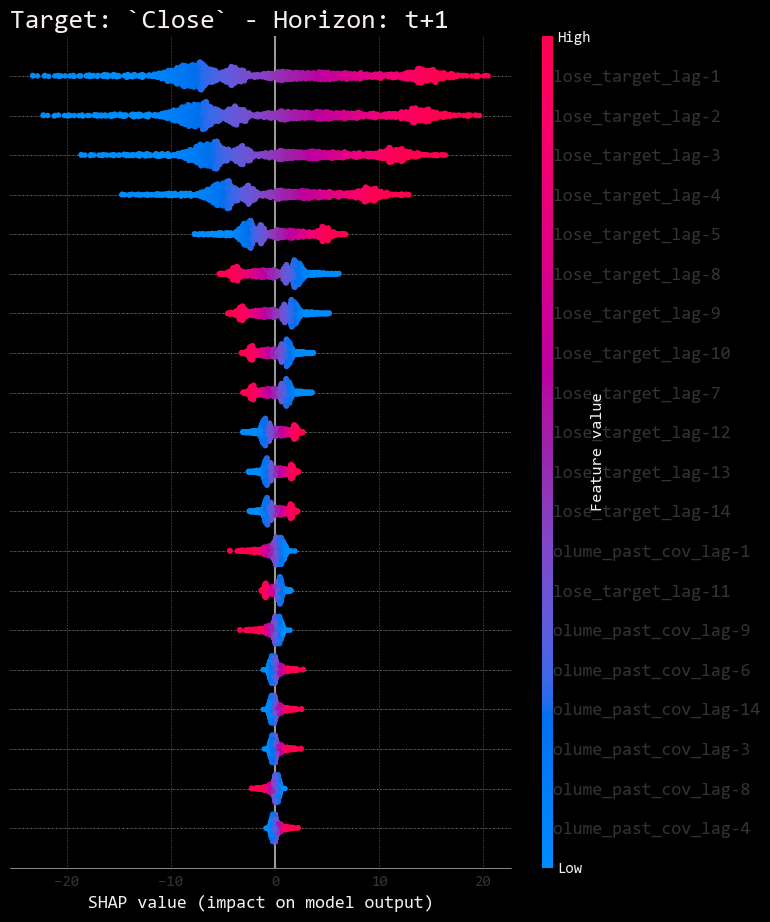

<Figure size 640x480 with 0 Axes>

In [79]:
openbb.forecast.regr_chart(data = new_iwm_df, target_column = "Close",
        n_predict = ,
        train_split = 0.75,
        forecast_horizon = 5,
        past_covariates = "Volume"
                          
)